# Comparison and Validation of 3D Aerodynamics Methods

Here, we compare some of AeroSandbox's 3D aerodynamics analysis methods to those from other tools.

This study utilizes data courtesy of John Yost.

Consider the following swept flying-wing airplane:

In [1]:
import aerosandbox as asb
import aerosandbox.numpy as np
from pathlib import Path

assets = Path("assets")

airplane = asb.Airplane(
    name="NACA_RM_A50K27 Wing",
    xyz_ref=[0.58508889, 0, 0],  # CG location
    wings=[
        asb.Wing(
            name="Main Wing",
            symmetric=True,  # Should this wing be mirrored across the XZ plane?
            xsecs=[  # The wing's cross ("X") sections
                asb.WingXSec(  # Root
                    xyz_le=[
                        0.0,
                        0,
                        0,
                    ],  # Coordinates of the XSec's leading edge, relative to the wing's leading edge.
                    chord=0.4120,
                    twist=0.0,  # degrees
                    airfoil=asb.Airfoil(
                        name="n64_1_A612", coordinates=assets / "n64_1_A612.dat"
                    ),  # Airfoils are blended between a given XSec and the next one.
                ),
                asb.WingXSec(
                    xyz_le=[1.1362, 1.5490, 0],
                    chord=0.2060,
                    twist=0,
                    airfoil=asb.Airfoil(
                        name="n64_1_A612", coordinates=assets / "n64_1_A612.dat"
                    ),
                ),
            ],
        )
    ],
    c_ref=0.32,
)

Visualize it:

C:\GitHub\AeroSandbox\aerosandbox\tools\pretty_plots\formatting.py:379: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


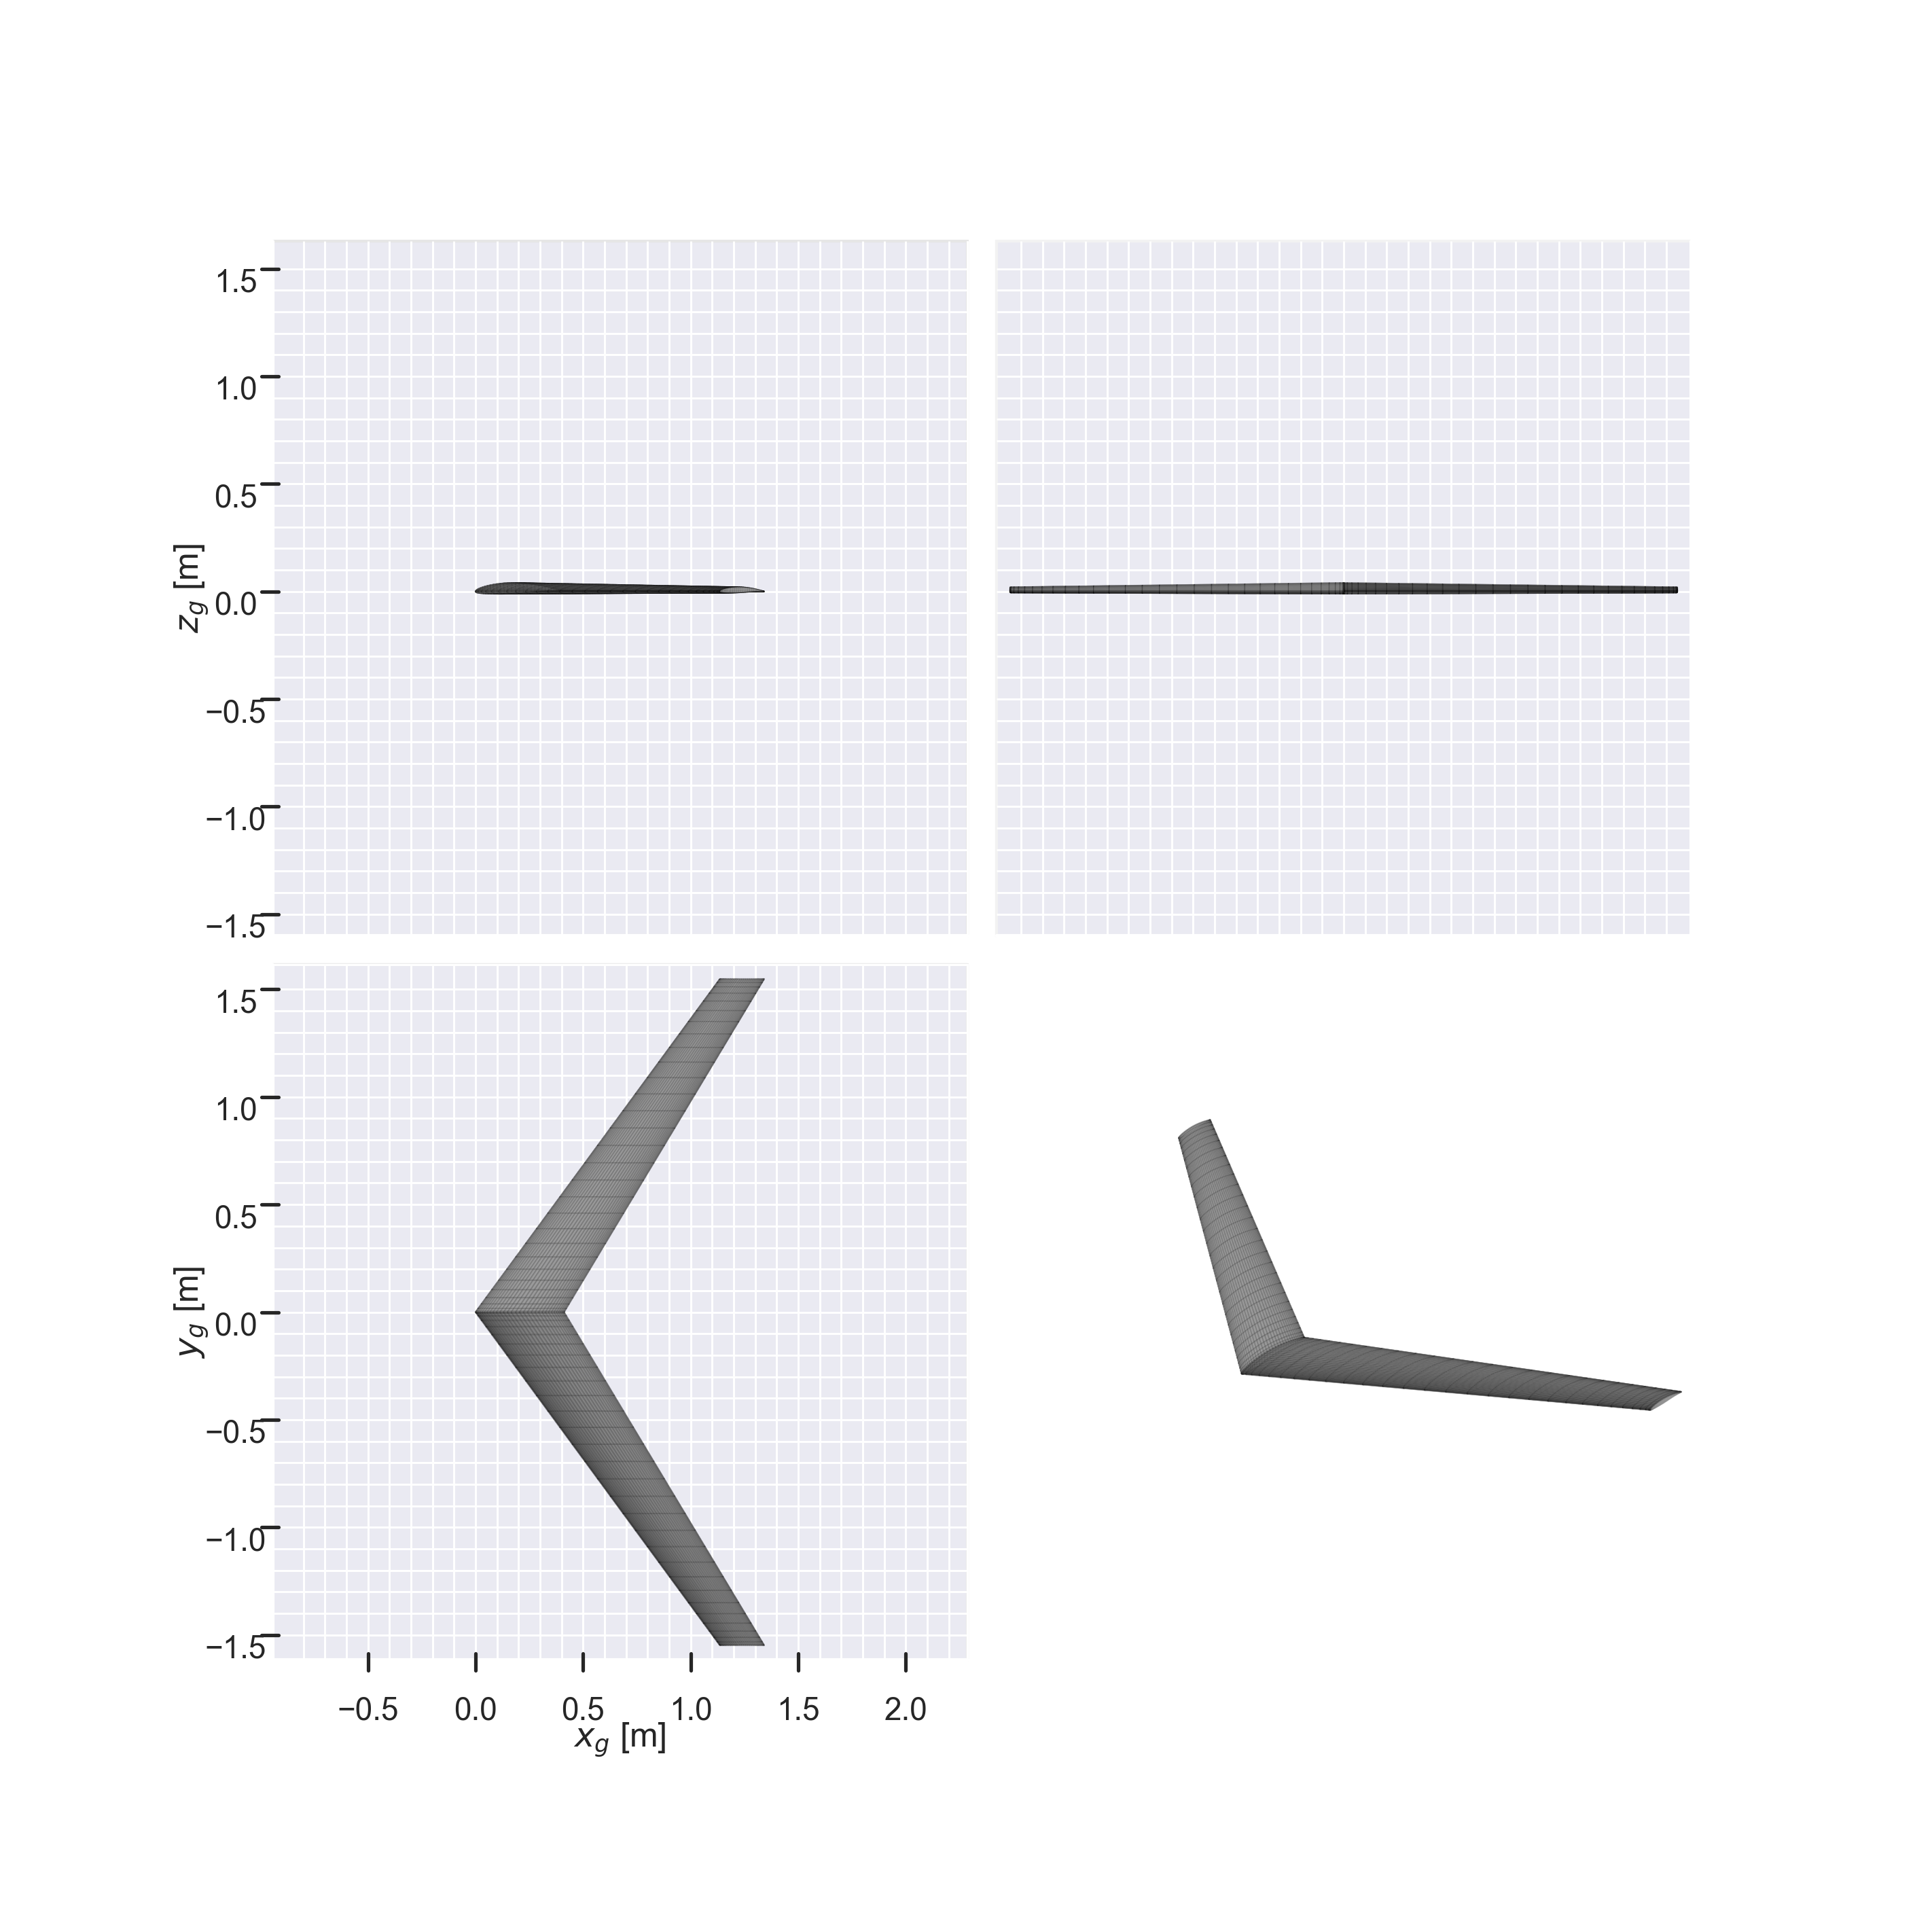

In [2]:
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

airplane.wings[0].subdivide_sections(30, spacing_function=np.cosspace).draw_three_view(
    show=False
)
p.show_plot(savefig="flying_wing_geometry.png", dpi=300)

We wish to analyze it at the following aerodynamic operating point:

In [3]:
op_point = asb.OperatingPoint(
    atmosphere=asb.Atmosphere(altitude=0),
    velocity=91.3,  # m/s
)

xyz_ref = [0.585, 0, 0]

while varying the angle of attack ($\alpha$).

## AeroBuildup Analysis

Analysis with AeroBuildup is simple, since it respects vectorization across operating points:

In [4]:
ab_op_point = op_point.copy()
ab_op_point.alpha = np.linspace(-12, 12, 50)

aerobuildup_aero = asb.AeroBuildup(
    airplane=airplane, op_point=ab_op_point, xyz_ref=xyz_ref
).run()
aerobuildup_aero["alpha"] = ab_op_point.alpha

aerobuildup_aero

{'F_g': [array([-3.48646021e+02, -3.03239004e+02, -2.60070223e+02, -2.19230913e+02,
         -1.80769701e+02, -1.44705209e+02, -1.11037481e+02, -7.97576216e+01,
         -5.08544485e+01, -2.43175390e+01, -1.37189787e-01,  2.16970667e+01,
          4.11968190e+01,  5.83703459e+01,  7.32093005e+01,  8.56669272e+01,
          9.56406033e+01,  1.02972159e+02,  1.07447915e+02,  1.08809999e+02,
          1.06902665e+02,  1.01923772e+02,  9.44447828e+01,  8.50487572e+01,
          7.39219688e+01,  6.08372651e+01,  4.54581897e+01,  2.75617910e+01,
          7.06577618e+00, -1.60185996e+01, -4.16323156e+01, -6.96997431e+01,
         -1.00149358e+02, -1.32922657e+02, -1.67953317e+02, -2.05105635e+02,
         -2.44102317e+02, -2.84517262e+02, -3.25918951e+02, -3.68131377e+02,
         -4.11393925e+02, -4.56279054e+02, -5.03441848e+02, -5.53306480e+02,
         -6.05885347e+02, -6.60875183e+02, -7.17878819e+02, -7.76559542e+02,
         -8.36688005e+02, -8.98123133e+02]),
  array([0., 0., 0., 0.,

## VortexLatticeMethod Analysis

Analysis with `asb.VortexLatticeMethod` is a smidge more work, since it isn't written in a way that allows vectorization across operating points (so, we have to iterate manually if we want to do an $\alpha$ sweep):

In [5]:
vlm_op_point = op_point.copy()
vlm_op_point.alpha = np.linspace(-12, 12, 13)

vlm_aeros = [
    asb.VortexLatticeMethod(
        airplane=airplane, op_point=op, xyz_ref=xyz_ref, spanwise_resolution=5
    ).run()
    for op in vlm_op_point
]

vlm_aero = {}

for k in vlm_aeros[0].keys():
    vlm_aero[k] = np.array([aero[k] for aero in vlm_aeros])
vlm_aero["alpha"] = vlm_op_point.alpha

vlm_aero

{'F_g': array([[-5.63825229e+02, -1.80550019e-14, -2.92138870e+03],
        [-3.55021317e+02,  2.81961954e-14, -2.19665565e+03],
        [-1.90287457e+02,  5.44703171e-16, -1.45736479e+03],
        [-7.04262146e+01, -1.29826705e-14, -7.07117892e+02],
        [ 3.97845756e+00, -3.68455266e-15,  5.04299289e+01],
        [ 3.25640676e+01, -3.31332184e-15,  8.11587972e+02],
        [ 1.51913493e+01, -6.57113253e-15,  1.57264795e+03],
        [-4.80550591e+01,  3.46944695e-16,  2.32990206e+03],
        [-1.56867028e+02,  1.34198208e-14,  3.07966104e+03],
        [-3.10714435e+02, -7.72368280e-14,  3.81827212e+03],
        [-5.08847753e+02,  3.79349330e-14,  4.54213688e+03],
        [-7.50301695e+02,  1.18287324e-13,  5.24772872e+03],
        [-1.03389992e+03,  3.01703107e-14,  5.93161006e+03]]),
 'F_b': array([[ 5.63825229e+02, -1.80550019e-14,  2.92138870e+03],
        [ 3.55021317e+02,  2.81961954e-14,  2.19665565e+03],
        [ 1.90287457e+02,  5.44703171e-16,  1.45736479e+03],
        

## Nonlinear Lifting Line Analysis

Similarly, `asb.NonlinearLiftingLine` doesn't allow vectorization across operating points:

In [6]:
nlll_op_point = op_point.copy()
nlll_op_point.alpha = np.linspace(-10, 10, 11)

nlll_aeros = [
    asb.NonlinearLiftingLine(
        airplane=airplane,
        op_point=op,
        xyz_ref=xyz_ref,
    ).run()
    for op in nlll_op_point
]

nlll_aero = {}
for k in nlll_aeros[0].keys():
    nlll_aero[k] = np.array([aero[k] for aero in nlll_aeros])
nlll_aero["alpha"] = nlll_op_point.alpha

nlll_aero

{'residuals': array([[-1.18177690e-12, -6.43374243e-14, -6.38378239e-15,
          0.00000000e+00, -5.21804822e-15, -4.88498131e-15,
         -8.21565038e-15, -4.38166170e-12, -1.18172139e-12,
         -6.43374243e-14, -6.55031585e-15, -6.99440506e-15,
         -5.44009282e-15, -5.32907052e-15, -8.32667268e-15,
         -4.38177272e-12],
        [-3.05311332e-15, -2.22044605e-16,  1.60982339e-15,
         -1.38777878e-15, -4.44089210e-16,  4.99600361e-16,
          2.77555756e-15,  1.16573418e-15, -3.08086889e-15,
         -2.22044605e-16,  1.66533454e-15, -1.38777878e-15,
         -4.44089210e-16,  9.99200722e-16,  2.44249065e-15,
          8.88178420e-16],
        [-8.12051981e-10, -8.55569782e-12, -2.36411446e-11,
         -2.75093837e-12,  5.98326944e-13, -1.22257759e-12,
         -3.36453088e-13, -2.39841480e-12, -8.12051981e-10,
         -8.55572557e-12, -2.36411446e-11, -2.75093837e-12,
          5.98326944e-13, -1.22277188e-12, -3.36675132e-13,
         -2.39797071e-12],
      

## (Quasi-Linear) Lifting Line Analysis

In [7]:
ll_op_point = op_point.copy()
ll_op_point.alpha = np.linspace(-12, 14, 31)

ll_aeros = [
    asb.LiftingLine(
        airplane=airplane,
        op_point=op,
        xyz_ref=xyz_ref,
    ).run()
    for op in ll_op_point
]

ll_aero = {}
for k in ll_aeros[0].keys():
    ll_aero[k] = np.array([aero[k] for aero in ll_aeros])
ll_aero["alpha"] = ll_op_point.alpha

ll_aero

{'F_g': array([[-2.69166756e+02, -5.32907052e-15, -1.94314890e+03],
        [-2.49467882e+02,  0.00000000e+00, -1.78747024e+03],
        [-2.02444655e+02, -1.77635684e-15, -1.58693075e+03],
        [-1.55407214e+02, -1.59872116e-14, -1.37217418e+03],
        [-1.11014245e+02,  4.44089210e-15, -1.14703201e+03],
        [-6.98431536e+01, -8.88178420e-16, -9.09612247e+02],
        [-3.26712377e+01, -4.44089210e-15, -6.59637754e+02],
        [-4.69904681e-01,  1.33226763e-15, -3.99162199e+02],
        [ 2.60001919e+01,  1.11022302e-16, -1.30263234e+02],
        [ 4.61654907e+01,  5.55111512e-17,  1.45351152e+02],
        [ 5.95189585e+01, -4.44089210e-16,  4.25425392e+02],
        [ 6.57418531e+01,  1.33226763e-15,  7.08929271e+02],
        [ 6.28288173e+01,  0.00000000e+00,  9.83666025e+02],
        [ 5.09320107e+01,  1.55431223e-15,  1.24187228e+03],
        [ 3.46933831e+01,  1.94289029e-16,  1.51905785e+03],
        [ 1.20935414e+01,  7.77156117e-16,  1.79898593e+03],
        [-1.76522

## AVL (External) Analysis

In [8]:
# avl_aeros = [
#     asb.AVL(
#         airplane=airplane,
#         op_point=op,
#         xyz_ref=xyz_ref,
#         working_directory=Path.home() / "Downloads" / "test",
#         verbose=True
#     ).run()
#     for op in op_point
# ]
#
# avl_aero = {}
#
# for k in vlm_aeros[0].keys():
#     avl_aero[k] = np.array([
#         aero[k]
#         for aero in avl_aeros
#     ])
#
# avl_aero

## Wind Tunnel Data

In [9]:
# From NACA-RM-A50K27
import assets.load_naca_data as naca

naca.CL, naca.CD, naca.Cm

(        alpha        CL
 0   -5.974260 -0.101053
 1   -4.974620 -0.023158
 2   -3.975150  0.052632
 3   -2.929820  0.136842
 4   -1.930350  0.212632
 5   -0.931063  0.286316
 6    0.068585  0.364211
 7    1.067880  0.437895
 8    2.067530  0.515789
 9    3.067350  0.595789
 10   4.111250  0.663158
 11   5.110540  0.736842
 12   6.108580  0.795789
 13   7.193520  0.814737
 14   8.098790  0.844211
 15   9.184440  0.871579
 16  10.180200  0.903158
 17  11.176400  0.941053
 18  12.172000  0.970526
 19  13.167400  0.997895,
           CD        CL
 0   0.008346  0.051216
 1   0.008390  0.133679
 2   0.009338  0.211938
 3   0.010285  0.288083
 4   0.010778  0.362101
 5   0.013538  0.438293
 6   0.014939  0.514450
 7   0.018607  0.594895
 8   0.022723  0.662665
 9   0.027296  0.738906
 10  0.031407  0.798218
 11  0.038683  0.842813
 12  0.043685  0.872548
 13  0.049595  0.906535
 14  0.057320  0.942684
 15  0.065495  0.974617
 16  0.074578  1.006570
 17  0.089097  1.034440
 18  0.103164  1.0

## Comparison and Validation

In [10]:
name_data_paths = {
    # "AVL 3.35 (inviscid)"   : assets / "avl.csv",
    "AVL + XFoil": assets / "avl_and_xfoil.csv",
    "Panel + IBL": assets / "panel_and_IBL.csv",
    "OpenVSP": assets / "openvsp_panel.csv",
}

import pandas as pd

name_data = {
    k: pd.read_csv(
        v,
    )
    for k, v in name_data_paths.items()
}

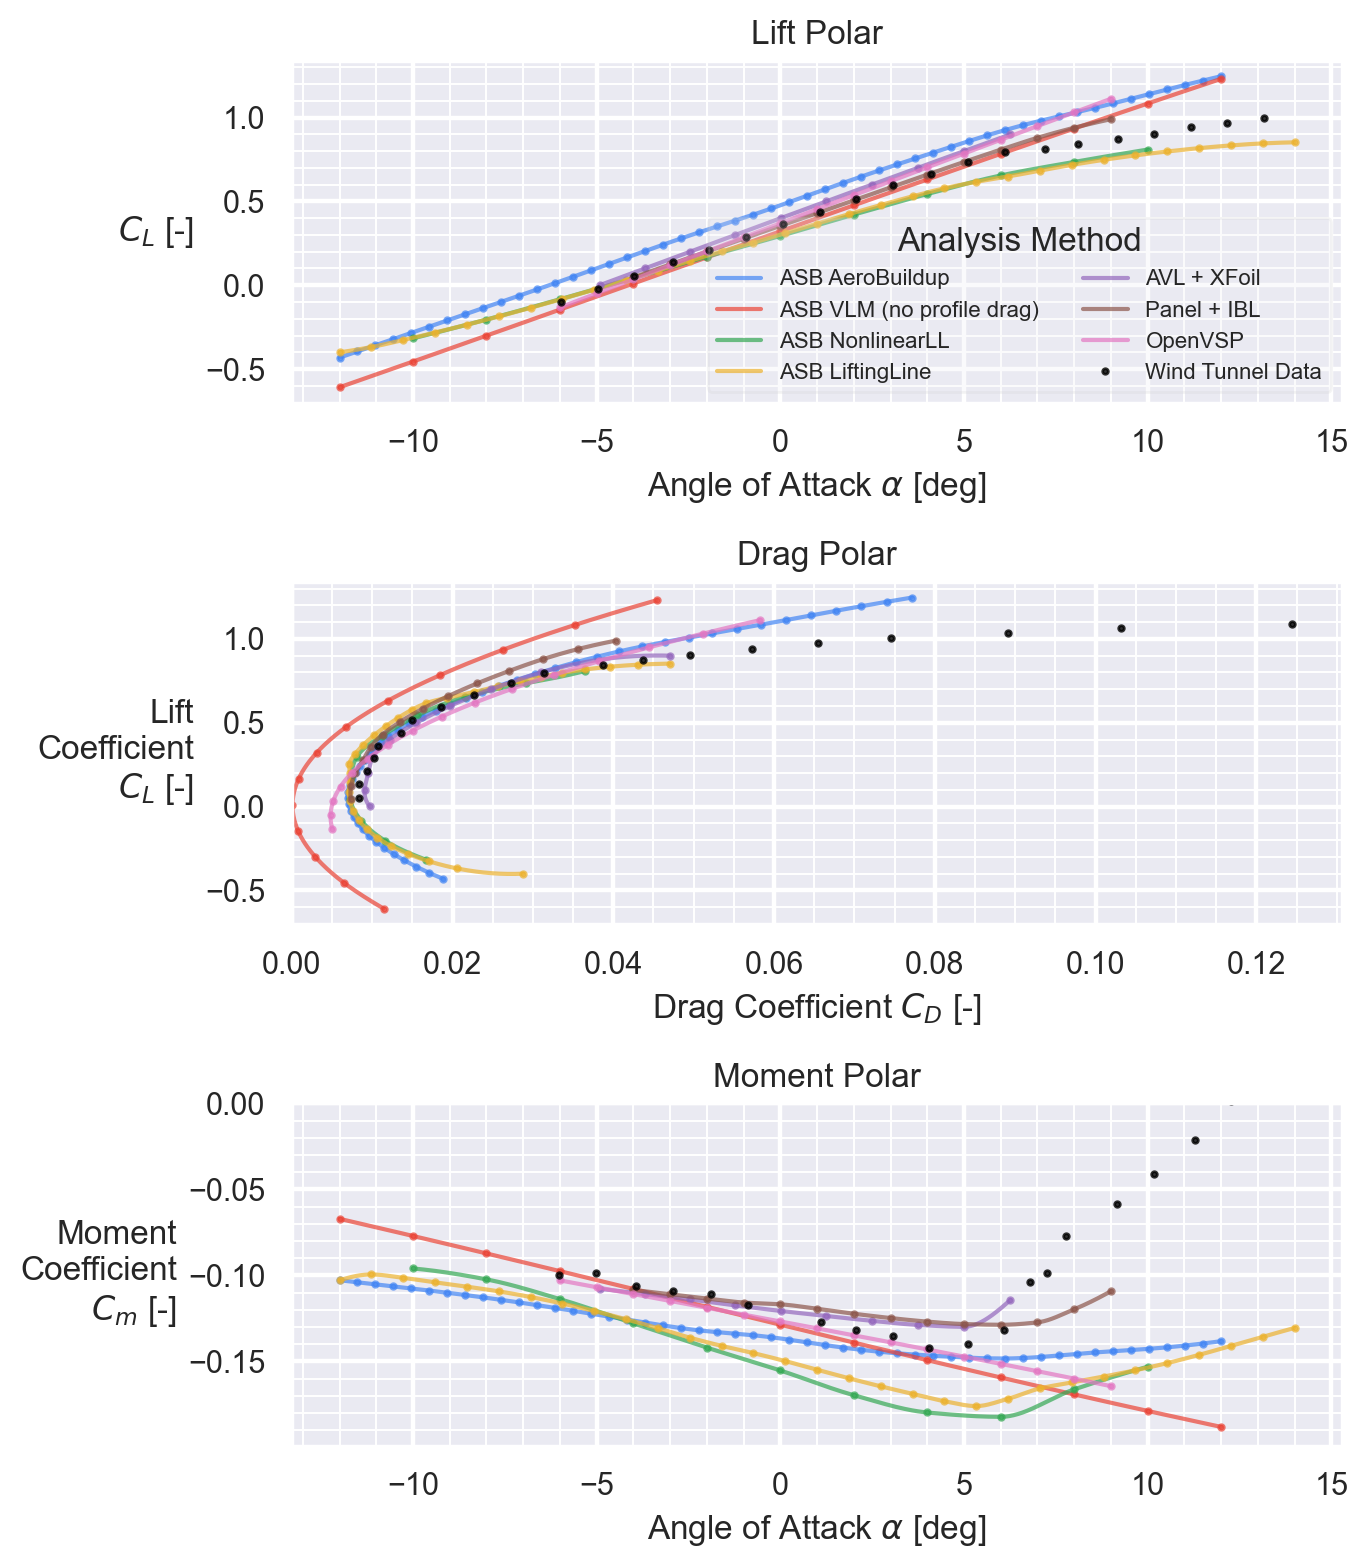

In [11]:
import aerosandbox.tools.pretty_plots as p

fig, ax = plt.subplots(3, 1, figsize=(7, 8), dpi=200)

for name, aero in {
    "ASB AeroBuildup": aerobuildup_aero,
    "ASB VLM (no profile drag)": vlm_aero,
    "ASB NonlinearLL": nlll_aero,
    "ASB LiftingLine": ll_aero,
    **name_data,
}.items():
    plt.sca(ax[0])
    p.plot_smooth(
        aero["alpha"],
        aero["CL"],
        label=name,
        function_of="x",
        alpha=0.7,
        markersize=4,
    )

    plt.sca(ax[1])
    p.plot_smooth(
        aero["CD"],
        aero["CL"],
        label=name,
        alpha=0.7,
        markersize=4,
    )

    plt.sca(ax[2])
    p.plot_smooth(
        aero["alpha"],
        aero["Cm"],
        label=name,
        function_of="x",
        alpha=0.7,
        markersize=4,
    )

# Plot wind tunnel data
fmt = dict(
    label="Wind Tunnel Data",
    color="black",
    linewidth=0,
    marker=".",
    markersize=4,
    alpha=0.8,
)
ax[0].plot(naca.CL["alpha"], naca.CL["CL"], **fmt)
ax[1].plot(naca.CD["CD"], naca.CD["CL"], **fmt)
ax[2].plot(naca.Cm["alpha"], naca.Cm["Cm"], **fmt)


ax[0].set_title("Lift Polar")
ax[0].set_xlabel("Angle of Attack $\\alpha$ [deg]")
ax[0].set_ylabel("$C_L$ [-]")

ax[1].set_title("Drag Polar")
ax[1].set_xlabel("Drag Coefficient $C_D$ [-]")
ax[1].set_ylabel("Lift Coefficient $C_L$ [-]")
ax[1].set_xlim(left=0)

ax[2].set_title("Moment Polar")
ax[2].set_xlabel("Angle of Attack $\\alpha$ [deg]")
ax[2].set_ylabel("Moment Coefficient $C_m$ [-]")
ax[2].set_ylim(top=0)  # Keep zero in view

ax[0].legend(title="Analysis Method", fontsize=8, framealpha=0.2, ncols=2)
p.show_plot(legend=False, savefig="flying_wing_polars.pdf")